# **Visual Information Processing and Management**
---
---

Università degli Studi Milano Bicocca \
CdLM Informatica — A.A 2025/2026

---
---

### **Componenti del gruppo:**
— Oleksandra Golub (856706) \
— Andrea Spagnolo (879254)




## **Librerie**


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image, ImageOps
from dataclasses import dataclass
from typing import Dict, Any, List, Tuple

from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.base import clone
from skimage import exposure
from skimage.restoration import denoise_bilateral
from sklearn.decomposition import PCA

from skimage.feature import hog, local_binary_pattern
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from torchvision import datasets

## **Configurazione**

In [2]:
@dataclass
class Config:
    # paths
    fit_dir  = "/kaggle/input/datasets/andreaspagnolo/visual-exam-dataset/visual_dataset/valid"
    #fit_dir: str = "/kaggle/input/visual-exam-dataset/visual_dataset/valid"
    test_dir = "/kaggle/input/datasets/andreaspagnolo/visual-exam-dataset/visual_dataset/test_degradato"
    #test_dir: str = "/kaggle/input/visual-exam-dataset/visual_dataset/test_degradato"
    
    img_size = 128   # per HOG spesso 128 va benissimo
    random_state = 42 # tuning
    max_iter = 50000 # tuning
    
def sanity_check_paths(cfg: Config):
    for p in [cfg.fit_dir, cfg.test_dir]:
        if not os.path.exists(p):
            raise FileNotFoundError(f"Path not found: {p}")
    print("OK paths")
    print("fit_dir:", cfg.fit_dir)
    print("test_dir:", cfg.test_dir)

## **Feature Extraction**

In [3]:
def preprocess_gray(img_gray, mode: str):
    # mode: "none", "clahe", "gamma", "bilat_clahe"
    if mode == "none":
        return img_gray

    x = img_gray.astype(np.float32) / 255.0

    if mode == "gamma":
        gamma = 0.8
        x = np.power(x, gamma)

    elif mode == "clahe":
        x = exposure.equalize_adapthist(x, clip_limit=0.005)

    elif mode == "bilat_clahe":
        x = denoise_bilateral(x, sigma_color=0.05, sigma_spatial=2, channel_axis=None)
        x = exposure.equalize_adapthist(x, clip_limit=0.01)

    x = np.clip(x, 0, 1)
    return (x * 255).astype(np.uint8)



def extract_hog(path, cfg, hog_conf, pre_mode):
    img = Image.open(path).convert("RGB")
    img = img.resize((cfg.img_size, cfg.img_size))
    gray = np.array(img.convert("L"))
    gray = preprocess_gray(gray, pre_mode)

    return hog(
        gray,
        orientations=hog_conf["orient"],
        pixels_per_cell=hog_conf["ppc"],
        cells_per_block=hog_conf["cpb"],
        block_norm="L2-Hys",
        transform_sqrt=True,
        feature_vector=True
    ).astype(np.float32)

def extract_lbp_hist(gray: np.ndarray, P=24, R=3, n_bins=None):
    """
    Estrae un istogramma LBP normalizzato (texture).
    gray: immagine grayscale uint8 (H,W)
    """
    lbp = local_binary_pattern(gray, P=P, R=R, method="uniform")

    # per method="uniform" il numero di pattern è P+2
    if n_bins is None:
        n_bins = P + 2

    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_bins + 1), range=(0, n_bins))
    hist = hist.astype(np.float32)
    hist /= (hist.sum() + 1e-6)
    return hist

def extract_hog_lbp(path, cfg, hog_conf, pre_mode, lbp_conf):
    img = Image.open(path).convert("RGB")
    img = img.resize((cfg.img_size, cfg.img_size))
    gray = np.array(img.convert("L"))

    gray = preprocess_gray(gray, pre_mode)

    hog_feat = hog(
        gray,
        orientations=hog_conf["orient"],
        pixels_per_cell=hog_conf["ppc"],
        cells_per_block=hog_conf["cpb"],
        block_norm="L2-Hys",
        transform_sqrt=True,
        feature_vector=True
    ).astype(np.float32)

    lbp_feat = extract_lbp_hist(
        gray,
        P=lbp_conf["P"],
        R=lbp_conf["R"],
        n_bins=lbp_conf.get("bins", None)
    )

    # concatenazione
    return np.concatenate([hog_feat, lbp_feat], axis=0).astype(np.float32)

In [4]:
# (mini-cache in RAM per non rifare la stessa roba)
_feat_cache = {}

def build_xy(folder, cfg, hog_conf, pre_mode, lbp_conf):
    X, y = [], []
    for path, label in folder.samples:
        X.append(extract_hog_lbp(path, cfg, hog_conf, pre_mode, lbp_conf))
        y.append(label)
    return np.array(X), np.array(y)

## **Utils**

In [5]:
def print_top_confusions(cm, class_names, top_k=30):
    cm_no_diag = cm.copy()
    np.fill_diagonal(cm_no_diag, 0)

    pairs = []
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            if i != j and cm_no_diag[i, j] > 0:
                pairs.append((i, j, cm_no_diag[i, j]))

    pairs_sorted = sorted(pairs, key=lambda x: x[2], reverse=True)

    print(f"\nTop {top_k} coppie più confuse:\n")
    for i, j, value in pairs_sorted[:top_k]:
        print(f"{class_names[i]} → {class_names[j]}  | {value} errori")


def build_model(model_name, C, use_pca=False, pca_n=256, max_iter=50000):
    steps = [("scaler", StandardScaler())]

    if use_pca:
        steps.append(("pca", PCA(n_components=pca_n, random_state=42)))

    if model_name == "LogReg":
        steps.append(("clf", LogisticRegression(max_iter=5000, C=C)))
    elif model_name == "LinearSVC":
        steps.append(("clf", LinearSVC(C=C, max_iter=max_iter)))
    else:
        raise ValueError("Model must be LogReg or LinearSVC")

    return Pipeline(steps)

## **Migliori configurazioni**

In [ ]:
BEST_CONFIGS: List[Dict[str, Any]] = [

    dict(
        tag="HOG12_LBP32",
        pre_mode="none",
        use_pca=False,
        hog=dict(orient=12, ppc=(16,16), cpb=(2,2)),
        lbp=dict(P=32, R=4),
        model="LogReg",
        C=3.0
    ),

    dict(
        tag="HOG16_LBP32",
        pre_mode="none",
        use_pca=False,
        hog=dict(orient=16, ppc=(16,16), cpb=(2,2)),
        lbp=dict(P=32, R=4),
        model="LogReg",
        C=3.0
    ),

    dict(
        tag="HOG18_LBP32",
        pre_mode="none",
        use_pca=False,
        hog=dict(orient=18, ppc=(16,16), cpb=(2,2)),
        lbp=dict(P=32, R=4),
        model="LogReg",
        C=3.0
    ),
]

## **Main**

In [7]:
cfg = Config()
np.random.seed(cfg.random_state)
sanity_check_paths(cfg)

OK paths
fit_dir: /kaggle/input/datasets/andreaspagnolo/visual-exam-dataset/visual_dataset/valid
test_dir: /kaggle/input/datasets/andreaspagnolo/visual-exam-dataset/visual_dataset/test_degradato


In [8]:
fit_ds  = datasets.ImageFolder(cfg.fit_dir)
test_ds = datasets.ImageFolder(cfg.test_dir)

assert fit_ds.classes == test_ds.classes, "Class order diverso tra fit e test!"
class_names = fit_ds.classes

print("Num classes:", len(class_names))
print("Fit samples:", len(fit_ds))
print("Test samples:", len(test_ds))

Num classes: 100
Fit samples: 500
Test samples: 500


In [9]:
all_results = {}
cms = {}

for conf in BEST_CONFIGS:
    print("\n" + "="*60)
    print(f"RUN: {conf['tag']}")
    print("="*60)

    X_fit, y_fit = build_xy(fit_ds, cfg, conf["hog"], conf["pre_mode"], conf["lbp"])
    X_test, y_test = build_xy(test_ds, cfg, conf["hog"], conf["pre_mode"], conf["lbp"])

    model = build_model(
        conf["model"],
        C=conf["C"],
        use_pca=conf["use_pca"],
        max_iter=cfg.max_iter
    )

    model.fit(X_fit, y_fit)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="macro", zero_division=0)
    cm = confusion_matrix(y_test, y_pred)

    print(f"Accuracy:  {acc:.4f}")
    print(f"Macro-F1:  {f1:.4f}")

    all_results[conf["tag"]] = {
        "acc": acc,
        "f1": f1,
        "C": conf["C"],
        "PCA": conf["use_pca"],
        "Pre": conf["pre_mode"],
        "HOG": conf["hog"]
    }
    cms[conf["tag"]] = cm


RUN: HOG12_LBP32
Accuracy:  0.1920
Macro-F1:  0.1733

RUN: HOG16_LBP32
Accuracy:  0.1920
Macro-F1:  0.1756

RUN: HOG18_LBP32
Accuracy:  0.1780
Macro-F1:  0.1663


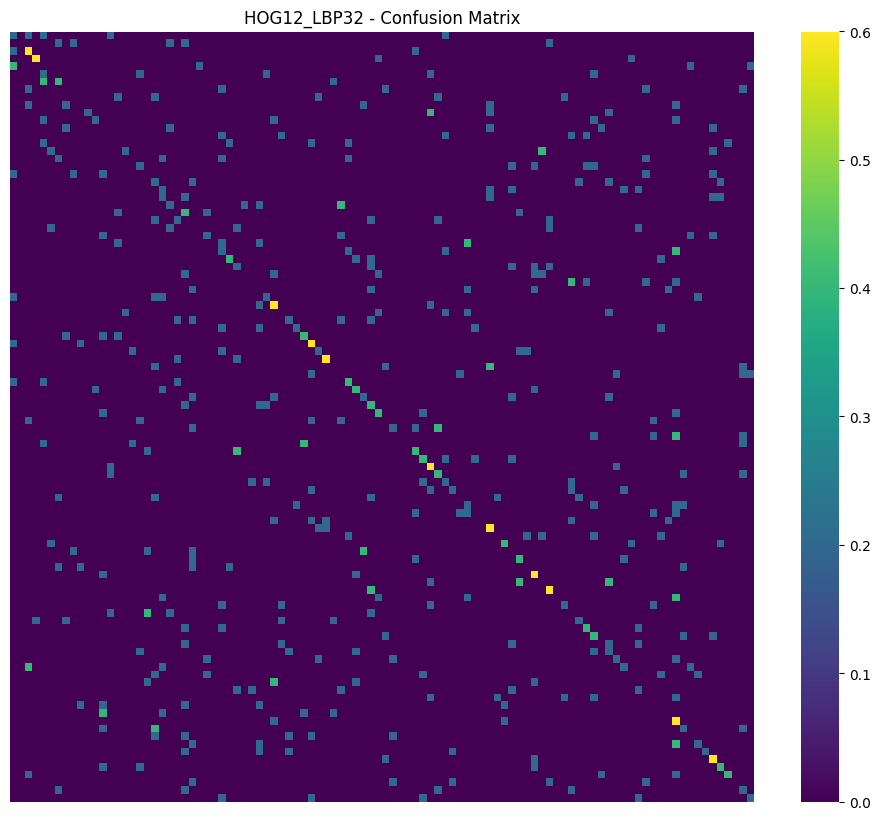


=== Top confusions: HOG12_LBP32 ===

Top 30 coppie più confuse:

axe throwing → air hockey  | 2 errori
barell racing → axe throwing  | 2 errori
bike polo → motorcycle racing  | 2 errori
boxing → rugby  | 2 errori
croquet → horseshoe pitching  | 2 errori
figure skating men → pole climbing  | 2 errori
figure skating pairs → trapeze  | 2 errori
formula 1 racing → sidecar racing  | 2 errori
horse racing → polo  | 2 errori
jousting → mushing  | 2 errori
judo → trapeze  | 2 errori
lacrosse → harness racing  | 2 errori
log rolling → fly fishing  | 2 errori
rock climbing → ice climbing  | 2 errori
rugby → roller derby  | 2 errori
rugby → snowmobile racing  | 2 errori
sailboat racing → ice yachting  | 2 errori
shot put → trapeze  | 2 errori
sidecar racing → canoe slamon  | 2 errori
steer wrestling → archery  | 2 errori
surfing → giant slalom  | 2 errori
track bicycle → bmx  | 2 errori
tug of war → cheerleading  | 2 errori
uneven bars → trapeze  | 2 errori
air hockey → archery  | 1 errori
air h

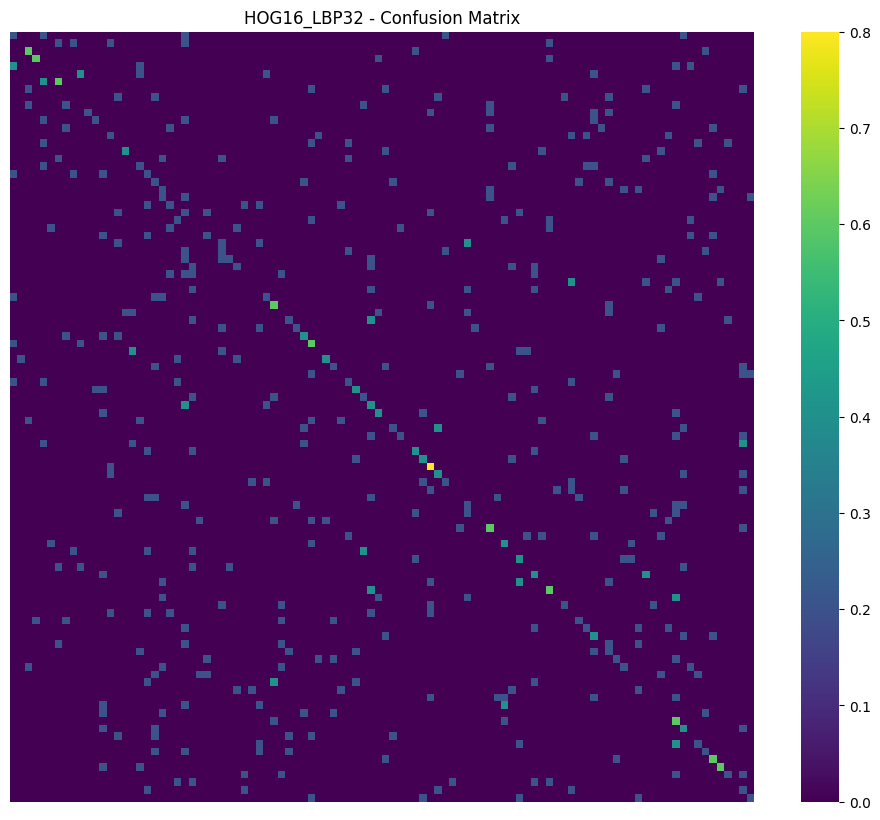


=== Top confusions: HOG16_LBP32 ===

Top 30 coppie più confuse:

axe throwing → air hockey  | 2 errori
balance beam → baton twirling  | 2 errori
barell racing → axe throwing  | 2 errori
figure skating men → pole climbing  | 2 errori
formula 1 racing → sidecar racing  | 2 errori
hammer throw → ice yachting  | 2 errori
hockey → bull riding  | 2 errori
ice yachting → curling  | 2 errori
jousting → mushing  | 2 errori
lacrosse → wheelchair racing  | 2 errori
rock climbing → ice climbing  | 2 errori
rowing → swimming  | 2 errori
rugby → roller derby  | 2 errori
sailboat racing → ice yachting  | 2 errori
shot put → trapeze  | 2 errori
surfing → giant slalom  | 2 errori
tennis → rings  | 2 errori
uneven bars → trapeze  | 2 errori
air hockey → axe throwing  | 1 errori
air hockey → curling  | 1 errori
air hockey → nascar racing  | 1 errori
air hockey → tug of war  | 1 errori
ampute football → barell racing  | 1 errori
ampute football → basketball  | 1 errori
ampute football → bobsled  | 1 erro

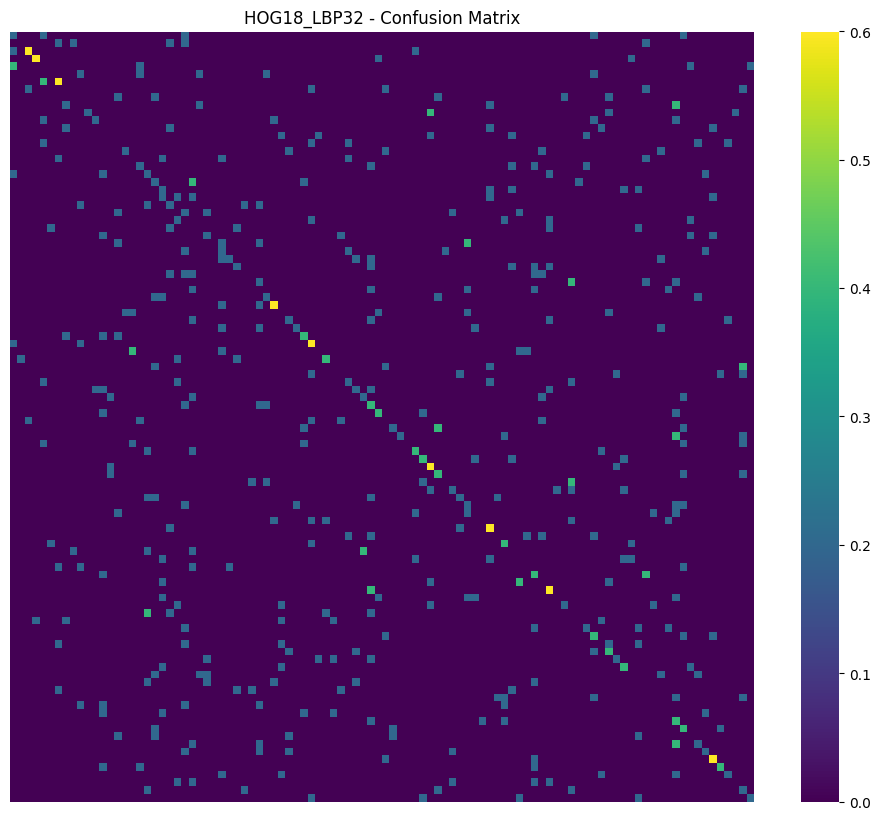


=== Top confusions: HOG18_LBP32 ===

Top 30 coppie più confuse:

axe throwing → air hockey  | 2 errori
barell racing → axe throwing  | 2 errori
baton twirling → trapeze  | 2 errori
bike polo → motorcycle racing  | 2 errori
cheerleading → disc golf  | 2 errori
figure skating men → pole climbing  | 2 errori
formula 1 racing → sidecar racing  | 2 errori
hockey → bull riding  | 2 errori
horse racing → wheelchair racing  | 2 errori
jousting → mushing  | 2 errori
judo → trapeze  | 2 errori
nascar racing → sidecar racing  | 2 errori
rock climbing → ice climbing  | 2 errori
rowing → swimming  | 2 errori
rugby → roller derby  | 2 errori
sailboat racing → ice yachting  | 2 errori
sidecar racing → canoe slamon  | 2 errori
uneven bars → trapeze  | 2 errori
air hockey → axe throwing  | 1 errori
air hockey → curling  | 1 errori
air hockey → skydiving  | 1 errori
air hockey → tug of war  | 1 errori
ampute football → barell racing  | 1 errori
ampute football → basketball  | 1 errori
ampute football →

In [10]:
for tag, cm in cms.items():
    cm_norm = cm / np.maximum(cm.sum(axis=1, keepdims=True), 1)

    plt.figure(figsize=(12,10))
    sns.heatmap(cm_norm, cmap="viridis", xticklabels=False, yticklabels=False)
    plt.title(f"{tag} - Confusion Matrix")
    plt.show()

    print(f"\n=== Top confusions: {tag} ===")
    print_top_confusions(cm, class_names, top_k=30)

In [11]:
print("\n" + "="*60)
print("FINAL SUMMARY (TOP-3)")
print("="*60)

for tag, data in all_results.items():
    print(
        f"{tag:8} | "
        f"Acc={data['acc']:.4f} | "
        f"F1={data['f1']:.4f} | "
        f"C={data['C']} | "
        f"PCA={data['PCA']} | "
        f"Pre={data['Pre']} | "
        f"HOG={data['HOG']}"
    )


FINAL SUMMARY (TOP-3)
HOG12_LBP32 | Acc=0.1920 | F1=0.1733 | C=3.0 | PCA=False | Pre=none | HOG={'orient': 12, 'ppc': (16, 16), 'cpb': (2, 2)}
HOG16_LBP32 | Acc=0.1920 | F1=0.1756 | C=3.0 | PCA=False | Pre=none | HOG={'orient': 16, 'ppc': (16, 16), 'cpb': (2, 2)}
HOG18_LBP32 | Acc=0.1780 | F1=0.1663 | C=3.0 | PCA=False | Pre=none | HOG={'orient': 18, 'ppc': (16, 16), 'cpb': (2, 2)}
